In [1]:
from tensorflow.keras import models
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import torch
from cpe.celeba import Generator, Encoder

import numpy as np
import matplotlib.pyplot as plt

2023-11-19 21:17:52.814694: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 21:17:52.851626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 21:17:54.318212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 21:17

In [2]:
mgen = models.load_model("keras/mnist/generator.h5")
menc = models.load_model("keras/mnist/encoder.h5")

cgen = Generator(100)
cgen.load_state_dict(torch.load("celeba_generator.pth"))
cenc = Encoder(100)
cenc.load_state_dict(torch.load("celeba_encoder.pth"))

<All keys matched successfully>

In [3]:
imagify = lambda img: img.detach().cpu().numpy().swapaxes(1, 2).swapaxes(2, 3) / 2 + 0.5
k2t = lambda img: torch.tensor(np.array(img)).detach()
t2k = lambda img: tf.convert_to_tensor(img.detach().numpy())

In [4]:
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

transform = Compose([Resize((64, 64)), ToTensor(), Normalize((0.5,), (0.5,))])
dataset = CelebA("/mnt/external/pytorch_datasets/", split="all", transform=transform, download=True)
dataloader = DataLoader(dataset, 16, shuffle=True)

/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Files already downloaded and verified


In [5]:
import tensorflow_datasets as tfds
ds = tfds.load("mnist", split="train", shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
ds = ds.map(lambda x: (tf.cast(x["image"], tf.float32) - 127.5) / 127.5)

# MNIST to CelebA

2023-11-19 21:18:01.071794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-11-19 21:18:01.072043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


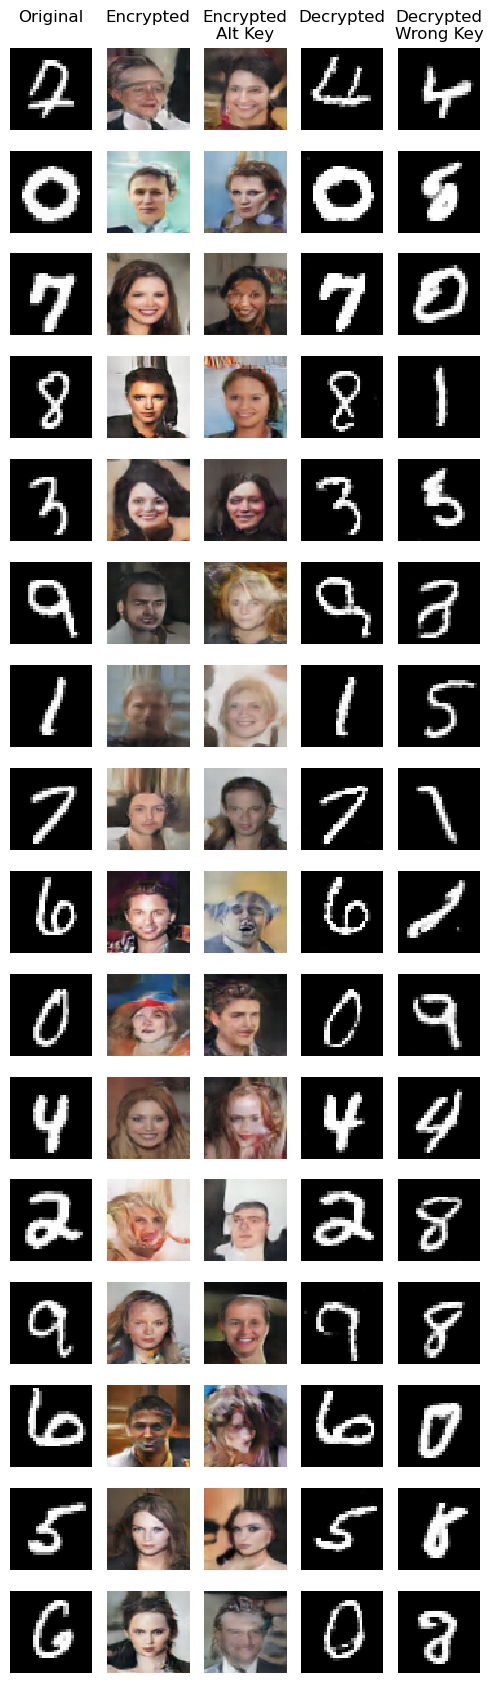

In [6]:
ss = lambda x, k: x * np.sign(k)
keygen = lambda: np.array((torch.rand(16, 100) * 2 - 1))
key = keygen()
alt_key = keygen()

pt = np.array(next(iter(ds.batch(16))))
pte = np.array(menc(pt))
ct = np.array(cgen(torch.tensor(ss(pte, key).reshape(16, 100, 1, 1))).detach())
at = np.array(cgen(torch.tensor(ss(pte, alt_key).reshape(16, 100, 1, 1))).detach())
cte = np.array(cenc(torch.tensor(ct)).detach())
rt = np.array(mgen(ss(cte.reshape(16, 100), key)))
wt = np.array(mgen(ss(cte.reshape(16, 100), alt_key)))

ci = lambda img: img.swapaxes(1, 2).swapaxes(2, 3) / 2 + 0.5
mi = lambda img: img.reshape(16, 28, 28)

pti = mi(pt)
cti = ci(ct)
ati = ci(at)
rti = mi(rt)
wti = mi(wt)

plt.figure(figsize=(5, 16 + 1))
cols = ["Original\n", "Encrypted\n", "Encrypted\nAlt Key", "Decrypted\n", "Decrypted\nWrong Key"]
for i in range(16):
    plt.subplot(16, 5, 5 * i + 1)
    plt.imshow(pti[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[0])
    plt.subplot(16, 5, 5 * i + 2)
    plt.imshow(cti[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[1])
    plt.subplot(16, 5, 5 * i + 3)
    plt.imshow(ati[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[2])
    plt.subplot(16, 5, 5 * i + 4)
    plt.imshow(rti[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[3])
    plt.subplot(16, 5, 5 * i + 5)
    plt.imshow(wti[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[4])
plt.tight_layout()
plt.savefig(f"hybrid_results.png", facecolor="w")
plt.show()